# Deepfake Image Classification with PyTorch

This notebook demonstrates a full workflow for classifying deepfake images using a convolutional neural network (CNN) in PyTorch. The steps include data exploration, preprocessing, model building, training, and evaluation, with visualizations and clear explanations throughout.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import os
from sklearn.metrics import roc_auc_score

## Preprocessing


### Visualize a Sample Image
Display a sample image from the dataset to verify image loading and format.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Display a sample image to verify loading
def show_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image("FF++/Fake/000_003/001_0.tiff")


### Explore Dataset Structure

In [ ]:
from pathlib import Path
def explore_dataset(root_dir):
    root = Path(root_dir)
    for category in root.iterdir():
        print(f"[{category.name}]")
        for person_folder in category.iterdir():
            print(f"  - {person_folder.name}: {len(list(person_folder.glob('*.tiff')))} images")
explore_dataset("FF++")


### Prepare the Dataset List
Create a list of image file paths and their corresponding labels for training and evaluation.

In [ ]:
from pathlib import Path

image_label_list = []

def prepare_dataset_list(root_dir):
    root = Path(root_dir)
    for label_str, label_num in [('Real', 0), ('Fake', 1)]:
        label_path = root / label_str
        if not label_path.exists():
            continue
        for person_folder in label_path.iterdir():
            if person_folder.is_dir():
                for image_path in person_folder.glob('*.tiff'):
                    image_label_list.append((str(image_path), label_num))
    return image_label_list
dataset_list = prepare_dataset_list("FF++")
print("Sampled Dataset Size:", len(dataset_list))
print("Sample:", dataset_list[:5])


note : we could've used the `load_dataset` from `datasets` but each dataset would be {'image': {'path': '/path/to/image.jpg', 'bytes': None}, 'label': 1} which is very long 

### Print Folder Names and Image Counts

This section demonstrates how to display the names of the folders and the number of images sampled from each folder to verify data sampling.

In [ ]:
def print_folder_image_counts(root_dir):
    sumImages = 0
    root = Path(root_dir)
    for label_str, label_num in [('real', 0), ('fake', 1)]:
        label_path = root / label_str
        if not label_path.exists():
            continue
        print(f"Category: {label_str}")
        dirs = sorted(label_path.iterdir())
        for person_folder in dirs:
            if person_folder.is_dir():
                image_count = len(list(person_folder.glob('*.tiff')))
                sumImages+=image_count
                print(f"Folder: {person_folder.name}, Images Taken: {image_count}")
    print(f'the total images in the {root_dir} directory is : {sumImages}')
print_folder_image_counts("FF++")

### Implement a Basic Data Loader
Convert image files to tensors and prepare them for model input using PyTorch utilities.

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import transforms

# # Step 1: Define a transform (resize, tensor, normalize)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)
# ])

# # Step 2: Prepare your dataset list
# def prepare_dataset(data_list, transform):
#     images = []
#     labels = []

#     for path, label in data_list:
#         print(f"Loading: {path}")  # Debug print
#         img = Image.open(path).convert('RGB')
#         img = transform(img)
#         print(f"Transformed shape: {img.shape}, dtype: {img.dtype}")  # Debug info
#         images.append(img)
#         labels.append(label)

#     return torch.stack(images), torch.tensor(labels)

# # Step 3: Example usage
# image_tensors, label_tensors = prepare_dataset(dataset_list, transform)
# print(image_tensors)

# # Now you can create a TensorDataset and DataLoader
# # from torch.utils.data import TensorDataset, DataLoader

# dataset = TensorDataset(image_tensors, label_tensors)
# loader = DataLoader(dataset, batch_size=16, shuffle=True)


### Implement Lazy Loading for Efficient Memory Usage

Use PyTorch's `Dataset` class to load images on-the-fly during training or evaluation, reducing memory usage. This approach avoids loading all images into memory at once.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class LazyDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label

# Example usage
lazy_dataset = LazyDataset(dataset_list, transform)
# loader = DataLoader(lazy_dataset, batch_size=16, shuffle=True) for testing only

# Iterate through the DataLoader
# for images, labels in loader:
#     print(f"Batch size: {images.size(0)}, Image shape: {images.shape}, Labels: {labels}")

In [ ]:
from torch.utils.data import random_split, DataLoader

# Train/test split and DataLoader creation
train_ratio = 0.8
# the test ratio will be automatically 0.2

# Calculate the sizes for training and testing sets
total_size = len(lazy_dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(lazy_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #imagine it as a pointer to the dataset and not the whole data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

# Example usage just to check
# for images, labels in train_loader:
#     print(f"Training batch - Images: {images.shape}, Labels: {labels}")

# for images, labels in test_loader:
#     print(f"Testing batch - Images: {images.shape}, Labels: {labels}")

In [2]:
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

real_root = Path("FF++/Real")
fake_root = Path("FF++/Fake")
#preparing the real folder
#get folder names for real folder
real_folders = sorted([f.name for f in real_root.iterdir() if f.is_dir()])
train_ids, test_ids = train_test_split(real_folders, test_size=0.2, random_state=42) #split the folders for testing and training

train_real_images = []
test_real_images = []
#prepare the tuple of (imgURL,label)
for folder in train_ids:
    for img in (real_root / folder).glob("*.tiff"):
        train_real_images.append((str(img), 0))

for folder in test_ids:
    for img in (real_root / folder).glob("*.tiff"):
        test_real_images.append((str(img), 0))

#preparing the fake folder
train_fake_images = []
test_fake_images = []

for fake_folder in fake_root.iterdir():
    if not fake_folder.is_dir():
        continue

    #for example 001_870 becomes 001 to match the real folder
    real_id = fake_folder.name.split('_')[0]
    
    # use the previous list of ids for testing and training to prepare or fake images to have the same split and content of persons
    if real_id in train_ids:
        for img in fake_folder.glob("*.tiff"):
            train_fake_images.append((str(img), 1))
    elif real_id in test_ids:
        for img in fake_folder.glob("*.tiff"):
            test_fake_images.append((str(img), 1))

train_data = train_real_images + train_fake_images
test_data = test_real_images + test_fake_images

print(f'train data : {train_data[:5]}')



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class LazyDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label


train_dataset = LazyDataset(train_data, transform)
print(train_dataset)
test_dataset = LazyDataset(test_data, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



train data : [('FF++\\Real\\055\\000_0.tiff', 0), ('FF++\\Real\\055\\001_0.tiff', 0), ('FF++\\Real\\055\\002_0.tiff', 0), ('FF++\\Real\\055\\003_0.tiff', 0), ('FF++\\Real\\055\\004_0.tiff', 0)]


### Visualize a Batch of Images
Display a batch of images from the DataLoader to verify preprocessing and data augmentation steps.

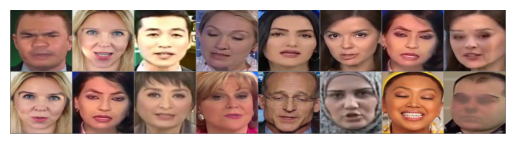

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(make_grid(images))

## Training With a simple CNN Model

### Define the CNN Model
Build a basic convolutional neural network (CNN) architecture for image classification using PyTorch.

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  ## only 2 outputs in here since it's between real and fake 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Training Loop and Visualization
Run the training loop and visualize loss and AUC metrics for each epoch and batch.

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### Training for Multiple Epochs
Iterate over the dataset for several epochs to optimize the model.

In [ ]:
# from sklearn.metrics import roc_auc_score
# epoch_aucs = []
# epoch_losses = []
# for epoch in range(2):
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
#     all_scores = []
#     all_labels = []
#     epoch_loss_sum = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         _, pred_cls = torch.max(outputs, 1)
#         correct_train += (pred_cls == labels).sum().item()
#         total_train += labels.size(0)
#         all_scores.append(outputs[:, 1].detach().cpu())
#         all_labels.append(labels.detach().cpu())
#         epoch_loss_sum += loss.item()
#         running_loss += loss.item()
#         if i % 200 == 199:
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
#             running_loss = 0.0
#     accuracy = 100 * correct_train / total_train
#     all_scores = torch.cat(all_scores)
#     all_labels = torch.cat(all_labels)
#     auc = roc_auc_score(all_labels.numpy(), all_scores.numpy())
#     epoch_aucs.append(auc)
#     epoch_losses.append(epoch_loss_sum / len(train_loader))
#     print(f'Epoch {epoch + 1} - Accuracy: {accuracy:.2f}%, AUC: {auc:.4f}, Loss: {epoch_loss_sum:.4f}')
# print('Finished Training')
# torch.save(net.state_dict(), "fake_image_model.pth")


In [ ]:
# import matplotlib.pyplot as plt

# # Plot Epoch Loss and AUC
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epoch_losses, marker='o')
# plt.title('Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.subplot(1, 2, 2)
# plt.plot(epoch_aucs, marker='o', color='green')
# plt.title('AUC per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('AUC')
# plt.tight_layout()
# plt.show()


#### Batch-Level CNN Training
Monitor and log loss, accuracy, and AUC for every batch during training.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

cnn_losses = []
cnn_accuracies = []
cnn_auc_scores = []
log_steps = 50  # 
epochs_count = 1

for epoch in range(epochs_count):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_scores = []
    all_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, pred_cls = torch.max(outputs, 1)
        correct_train += (pred_cls == labels).sum().item()
        total_train += labels.size(0)

        all_scores.append(outputs[:, 1].detach().cpu())
        all_labels.append(labels.detach().cpu())

        running_loss += loss.item()

        if i % log_steps == log_steps - 1:
            avg_loss = running_loss / log_steps
            cnn_losses.append(avg_loss)
            current_accuracy = 100 * correct_train / total_train
            cnn_accuracies.append(current_accuracy)
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')
            cnn_auc_scores.append(partial_auc)

            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_scores = []
            all_labels = []

    print(f'Epoch {epoch + 1} done.\n')

print('Finished Training')
torch.save(net.state_dict(), "fake_image_model.pth")


[1,    50] loss: 0.690, accuracy: 53.25%, AUC: 0.5393
[1,   100] loss: 0.588, accuracy: 68.38%, AUC: 0.7512
[1,   150] loss: 0.442, accuracy: 78.12%, AUC: 0.8725
[1,   200] loss: 0.348, accuracy: 83.62%, AUC: 0.9246
[1,   250] loss: 0.325, accuracy: 86.00%, AUC: 0.9361
[1,   300] loss: 0.237, accuracy: 89.75%, AUC: 0.9670
[1,   350] loss: 0.202, accuracy: 92.50%, AUC: 0.9756
[1,   400] loss: 0.170, accuracy: 94.00%, AUC: 0.9821
[1,   450] loss: 0.144, accuracy: 94.00%, AUC: 0.9866
[1,   500] loss: 0.111, accuracy: 96.62%, AUC: 0.9919
[1,   550] loss: 0.118, accuracy: 95.12%, AUC: 0.9914
[1,   600] loss: 0.110, accuracy: 96.00%, AUC: 0.9921
[1,   650] loss: 0.091, accuracy: 97.12%, AUC: 0.9942
[1,   700] loss: 0.062, accuracy: 97.88%, AUC: 0.9971
[1,   750] loss: 0.056, accuracy: 98.25%, AUC: 0.9975
[1,   800] loss: 0.122, accuracy: 95.62%, AUC: 0.9902
[1,   850] loss: 0.089, accuracy: 97.12%, AUC: 0.9939
[1,   900] loss: 0.092, accuracy: 96.88%, AUC: 0.9948
[1,   950] loss: 0.039, accu

### Training with a mobilenet_v2 model

In [9]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
# Load MobileNetV2 with pretrained weights
mobilenet = models.mobilenet_v2(weights=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=1e-4)
# Replace final layer for binary classification (1 output)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1)

# Send to device
mobilenet = mobilenet.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=0.001)

# Training loop
mobilenet.train()


mobilNet_losses = []
mobilNet_accuracies = []
mobilNet_auc_scores = []
log_steps = 50  # Every 200 batches
epochs_count = 1 # number of epoches

for epoch in range(epochs_count):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_scores = []
    all_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Shape: [batch_size, 1]

        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # predictions and accuracy
        pred_cls = (torch.sigmoid(outputs) > 0.5).float() ## Applies the sigmoid activation to raw like [[3.2], [-1.1], [0.0], [2.4], ...] to true or false preditions .float() converts them to 1 or 0 
        correct_train += (pred_cls == labels).sum().item()
        total_train += labels.size(0)

        all_scores.append(outputs.detach().cpu().squeeze())  
        all_labels.append(labels.detach().cpu())

        # Add running loss
        running_loss += loss.item()

        # Every 200 batches we save the loss / accuracy / AUC
        if i % log_steps == log_steps - 1:
            avg_loss = running_loss / log_steps
            mobilNet_losses.append(avg_loss)
            current_accuracy = 100 * correct_train / total_train
            mobilNet_accuracies.append(current_accuracy)
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            mobilNet_auc_scores.append(partial_auc)

            # Reset stats
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_scores = []
            all_labels = []

    print(f'Epoch {epoch + 1} done.\n')

print('Finished Training')
torch.save(mobilenet.state_dict(), "fake_image_model_mobilenetCPU.pth")


[1,    50] loss: 0.709, accuracy: 54.25%, AUC: 0.5575
[1,   100] loss: 0.606, accuracy: 66.75%, AUC: 0.7364
[1,   150] loss: 0.605, accuracy: 67.50%, AUC: 0.7319
[1,   200] loss: 0.540, accuracy: 72.25%, AUC: 0.8047
[1,   250] loss: 0.509, accuracy: 73.75%, AUC: 0.8290
[1,   300] loss: 0.496, accuracy: 74.88%, AUC: 0.8350
[1,   350] loss: 0.427, accuracy: 80.62%, AUC: 0.8859
[1,   400] loss: 0.416, accuracy: 81.62%, AUC: 0.8917
[1,   450] loss: 0.361, accuracy: 84.88%, AUC: 0.9198
[1,   500] loss: 0.362, accuracy: 83.12%, AUC: 0.9180
[1,   550] loss: 0.314, accuracy: 87.25%, AUC: 0.9408
[1,   600] loss: 0.255, accuracy: 88.75%, AUC: 0.9608
[1,   650] loss: 0.255, accuracy: 89.38%, AUC: 0.9600
[1,   700] loss: 0.225, accuracy: 91.12%, AUC: 0.9691
[1,   750] loss: 0.208, accuracy: 92.00%, AUC: 0.9734
[1,   800] loss: 0.235, accuracy: 90.88%, AUC: 0.9664
[1,   850] loss: 0.224, accuracy: 91.38%, AUC: 0.9690
[1,   900] loss: 0.192, accuracy: 92.38%, AUC: 0.9774
[1,   950] loss: 0.183, accu

### Visualization of the Models

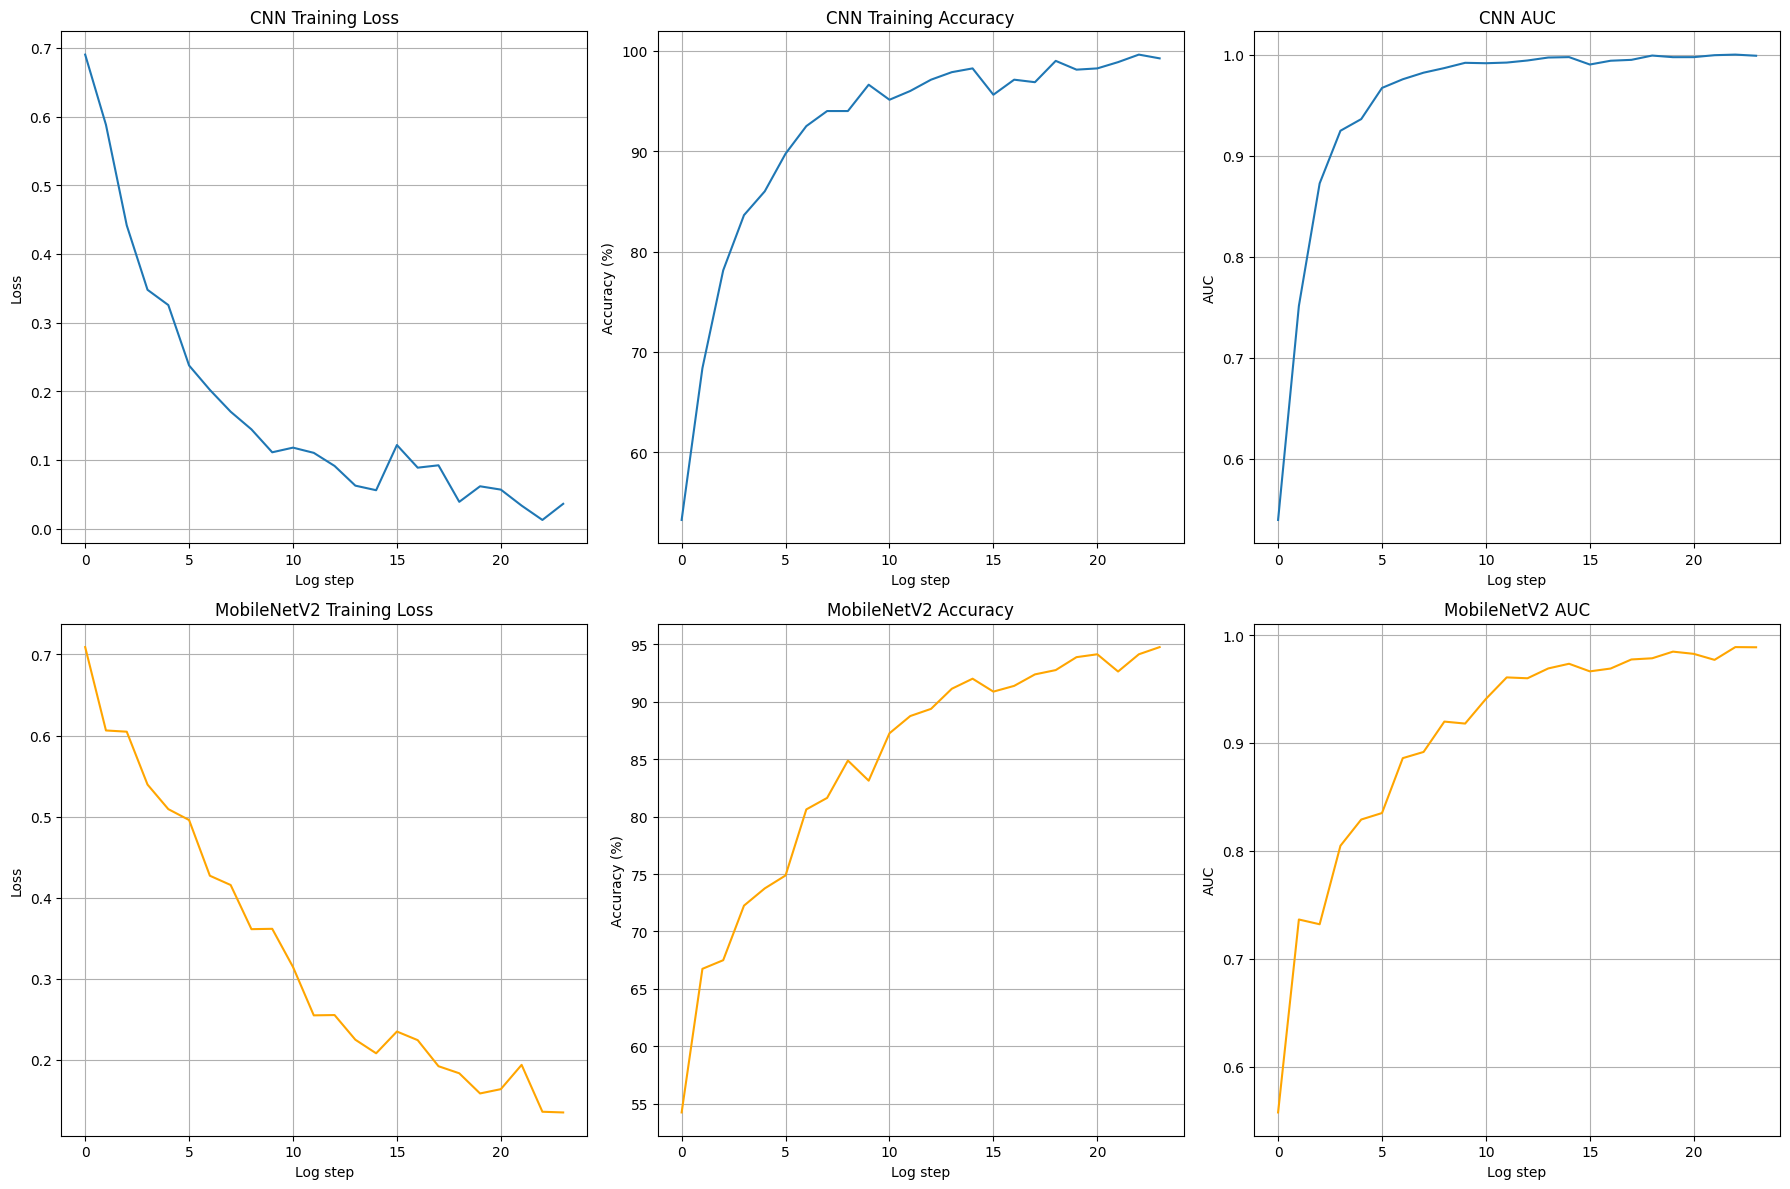

In [17]:
import matplotlib.pyplot as plt

steps = range(len(cnn_losses))

plt.figure(figsize=(18, 12))

# === CNN Model ===
plt.subplot(2, 3, 1)
plt.plot(steps, cnn_losses, label="CNN Loss")
plt.title("CNN Training Loss")
plt.xlabel("Log step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(steps, cnn_accuracies, label="CNN Accuracy")
plt.title("CNN Training Accuracy")
plt.xlabel("Log step")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(steps, cnn_auc_scores, label="CNN AUC")
plt.title("CNN AUC")
plt.xlabel("Log step")
plt.ylabel("AUC")
plt.grid(True)

# === MobileNet ===
steps = range(len(mobilNet_losses))

plt.subplot(2, 3, 4)
plt.plot(steps, mobilNet_losses, label="MobileNet Loss", color='orange')
plt.title("MobileNetV2 Training Loss")
plt.xlabel("Log step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(steps, mobilNet_accuracies, label="MobileNet Accuracy", color='orange')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Log step")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(steps, mobilNet_auc_scores, label="MobileNet AUC", color='orange')
plt.title("MobileNetV2 AUC")
plt.xlabel("Log step")
plt.ylabel("AUC")
plt.grid(True)

plt.tight_layout()
plt.show()


### Testing and Visualization
Evaluate the trained model on the test set and visualize the results.

#### Test Metrics per Epoch
Track and visualize loss and AUC for each test epoch.

In [ ]:
# # Testing loop
# test_aucs = []  # Initialize list to store AUC values
# test_losses = []  # Initialize list to store loss values

# with torch.no_grad():  # Disable gradient computation for testing
#     running_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_scores = []
#     all_labels = []

#     for i, data in enumerate(test_loader, 0):
#         inputs, labels = data
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         _, pred_cls = torch.max(outputs, 1)
#         correct_test += (pred_cls == labels).sum().item()
#         total_test += labels.size(0)
#         all_scores.append(outputs[:, 1].detach().cpu())  # Assuming binary classification
#         all_labels.append(labels.detach().cpu())

#         running_loss += loss.item()
    
    
#     accuracy = 100 * correct_test / total_test
#     all_scores = torch.cat(all_scores)
#     all_labels = torch.cat(all_labels)
#     auc = roc_auc_score(all_labels.numpy(), all_scores.numpy())
#     test_aucs.append(auc)  # Save AUC for testing
#     test_losses.append(running_loss)  # Save total loss for testing
#     print(f'Test - Accuracy: {accuracy:.2f}%, AUC: {auc:.4f}, Loss: {running_loss:.4f}')



In [ ]:
# # Plot Loss and AUC
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', label='Loss')
# plt.title('Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(test_aucs) + 1), test_aucs, marker='o', label='AUC')
# plt.title('Test AUC')
# plt.xlabel('Epoch')
# plt.ylabel('AUC')
# plt.legend()
# plt.tight_layout()
# plt.show()

#### Test Metrics per mini-batches

In [18]:
device = torch.device("cpu")
net.load_state_dict(torch.load("fake_image_model.pth", map_location=device))
net = net.to(device)
net.eval()
criterion = torch.nn.CrossEntropyLoss()

log_steps = 5
test_losses = []
test_accuracies = []
test_auc_scores = []

running_loss = 0.0
correct_test = 0
total_test = 0
all_scores = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  # will be on CPU
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, pred_cls = torch.max(outputs, 1)
        correct_test += (pred_cls == labels).sum().item()
        total_test += labels.size(0)

        all_scores.append(outputs[:, 1].detach().cpu())  # already on CPU
        all_labels.append(labels.detach().cpu())

        running_loss += loss.item()

        if (i + 1) % log_steps == 0:
            avg_loss = running_loss / log_steps
            current_accuracy = 100 * correct_test / total_test
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            test_losses.append(avg_loss)
            test_accuracies.append(current_accuracy)
            test_auc_scores.append(partial_auc)

            print(f'Test batches [{i + 1 - log_steps + 1}–{i + 1}]: '
                  f'Loss: {avg_loss:.4f}, Accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            running_loss = 0.0
            correct_test = 0
            total_test = 0
            all_scores = []
            all_labels = []

print('Finished Testing CNN')

C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [1–5]: Loss: 0.0026, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [6–10]: Loss: 1.7117, Accuracy: 62.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [11–15]: Loss: 0.9733, Accuracy: 57.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [16–20]: Loss: 1.8957, Accuracy: 31.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [21–25]: Loss: 2.8449, Accuracy: 16.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [26–30]: Loss: 1.8586, Accuracy: 18.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [31–35]: Loss: 0.0142, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [36–40]: Loss: 0.0329, Accuracy: 98.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [41–45]: Loss: 0.0241, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [46–50]: Loss: 0.0055, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [51–55]: Loss: 0.6805, Accuracy: 77.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [56–60]: Loss: 1.4363, Accuracy: 43.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [61–65]: Loss: 0.3184, Accuracy: 95.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [66–70]: Loss: 2.6331, Accuracy: 48.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [71–75]: Loss: 2.4250, Accuracy: 31.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [76–80]: Loss: 2.7554, Accuracy: 36.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [81–85]: Loss: 0.4159, Accuracy: 93.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [86–90]: Loss: 0.1034, Accuracy: 96.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [91–95]: Loss: 0.0148, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [96–100]: Loss: 0.4986, Accuracy: 85.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [101–105]: Loss: 3.0116, Accuracy: 11.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [106–110]: Loss: 0.0374, Accuracy: 98.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [111–115]: Loss: 0.5520, Accuracy: 81.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [116–120]: Loss: 0.6439, Accuracy: 71.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [121–125]: Loss: 0.0224, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [126–130]: Loss: 0.0068, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [131–135]: Loss: 0.0015, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [136–140]: Loss: 3.1262, Accuracy: 23.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [141–145]: Loss: 0.7539, Accuracy: 75.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [146–150]: Loss: 0.7098, Accuracy: 68.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [151–155]: Loss: 0.0094, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [156–160]: Loss: 0.0362, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [161–165]: Loss: 0.0000, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [166–170]: Loss: 0.0005, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [171–175]: Loss: 2.1219, Accuracy: 51.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [176–180]: Loss: 5.7066, Accuracy: 0.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [181–185]: Loss: 0.0260, Accuracy: 98.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [186–190]: Loss: 0.0205, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [191–195]: Loss: 0.0003, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [196–200]: Loss: 2.8450, Accuracy: 25.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [201–205]: Loss: 1.7691, Accuracy: 55.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [206–210]: Loss: 0.0046, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [211–215]: Loss: 2.5544, Accuracy: 43.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [216–220]: Loss: 0.3603, Accuracy: 85.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [221–225]: Loss: 0.2251, Accuracy: 93.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [226–230]: Loss: 0.0627, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [231–235]: Loss: 0.0259, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [236–240]: Loss: 0.0011, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [241–245]: Loss: 0.0466, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [246–250]: Loss: 0.6444, Accuracy: 83.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [251–255]: Loss: 1.5368, Accuracy: 56.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [256–260]: Loss: 0.5700, Accuracy: 85.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [261–265]: Loss: 0.5284, Accuracy: 83.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [266–270]: Loss: 0.0000, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [271–275]: Loss: 1.1298, Accuracy: 47.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [276–280]: Loss: 1.4531, Accuracy: 61.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [281–285]: Loss: 0.6055, Accuracy: 71.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [286–290]: Loss: 0.2905, Accuracy: 90.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Test batches [291–295]: Loss: 0.4912, Accuracy: 81.25%, AUC: nan
Test batches [296–300]: Loss: 0.0001, Accuracy: 100.00%, AUC: nan
Finished Testing CNN


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [19]:
import torchvision.models as models
import torch.nn as nn
import torch
from sklearn.metrics import roc_auc_score

# --- MobileNet Testing ---
device_mobilenet = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1)

mobilenet.load_state_dict(torch.load("fake_image_model_mobilenetCPU.pth", map_location=device_mobilenet))
mobilenet = mobilenet.to(device_mobilenet)
mobilenet.eval()

criterion_mobilenet = nn.BCEWithLogitsLoss()

log_steps_mobilenet = 5
test_losses_mobilenet = []
test_accuracies_mobilenet = []
test_auc_scores_mobilenet = []

running_loss_mobilenet = 0.0
correct_test_mobilenet = 0
total_test_mobilenet = 0
all_scores_mobilenet = []
all_labels_mobilenet = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device_mobilenet)
        labels = labels.float().unsqueeze(1).to(device_mobilenet)

        outputs = mobilenet(inputs)
        loss = criterion_mobilenet(outputs, labels)

        probs = torch.sigmoid(outputs)
        pred_cls = (probs > 0.5).float()

        correct_test_mobilenet += (pred_cls == labels).sum().item()
        total_test_mobilenet += labels.size(0)

        all_scores_mobilenet.append(outputs.detach().cpu().squeeze())
        all_labels_mobilenet.append(labels.detach().cpu())

        running_loss_mobilenet += loss.item()

        if (i + 1) % log_steps_mobilenet == 0:
            avg_loss = running_loss_mobilenet / log_steps_mobilenet
            current_accuracy = 100 * correct_test_mobilenet / total_test_mobilenet
            partial_scores = torch.cat(all_scores_mobilenet)
            partial_labels = torch.cat(all_labels_mobilenet)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            test_losses_mobilenet.append(avg_loss)
            test_accuracies_mobilenet.append(current_accuracy)
            test_auc_scores_mobilenet.append(partial_auc)

            print(f'MobileNet Test batches [{i + 1 - log_steps_mobilenet + 1}–{i + 1}]: '
                  f'Loss: {avg_loss:.4f}, Accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            running_loss_mobilenet = 0.0
            correct_test_mobilenet = 0
            total_test_mobilenet = 0
            all_scores_mobilenet = []
            all_labels_mobilenet = []

print('Finished Testing MobileNet')





C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [1–5]: Loss: 0.0023, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [6–10]: Loss: 0.2034, Accuracy: 92.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [11–15]: Loss: 0.1446, Accuracy: 95.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [16–20]: Loss: 0.5344, Accuracy: 70.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [21–25]: Loss: 0.8190, Accuracy: 63.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [26–30]: Loss: 0.2624, Accuracy: 91.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [31–35]: Loss: 0.0001, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [36–40]: Loss: 0.0216, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [41–45]: Loss: 0.0958, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [46–50]: Loss: 0.0084, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [51–55]: Loss: 0.1325, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [56–60]: Loss: 0.0932, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [61–65]: Loss: 0.0054, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [66–70]: Loss: 0.1719, Accuracy: 90.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [71–75]: Loss: 0.6449, Accuracy: 65.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [76–80]: Loss: 0.2722, Accuracy: 86.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [81–85]: Loss: 0.0471, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [86–90]: Loss: 0.1873, Accuracy: 96.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [91–95]: Loss: 0.0000, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [96–100]: Loss: 1.6867, Accuracy: 50.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [101–105]: Loss: 2.4080, Accuracy: 6.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [106–110]: Loss: 0.0014, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [111–115]: Loss: 0.2541, Accuracy: 85.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [116–120]: Loss: 0.1738, Accuracy: 93.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [121–125]: Loss: 0.1860, Accuracy: 91.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [126–130]: Loss: 0.0256, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [131–135]: Loss: 0.2088, Accuracy: 92.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [136–140]: Loss: 0.5910, Accuracy: 78.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [141–145]: Loss: 0.2012, Accuracy: 90.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [146–150]: Loss: 0.0245, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [151–155]: Loss: 0.3297, Accuracy: 78.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [156–160]: Loss: 0.5393, Accuracy: 72.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [161–165]: Loss: 0.2254, Accuracy: 90.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [166–170]: Loss: 0.4763, Accuracy: 77.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [171–175]: Loss: 1.5519, Accuracy: 40.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [176–180]: Loss: 3.2319, Accuracy: 1.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [181–185]: Loss: 0.6125, Accuracy: 70.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [186–190]: Loss: 1.7501, Accuracy: 30.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [191–195]: Loss: 3.7300, Accuracy: 0.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [196–200]: Loss: 0.0587, Accuracy: 97.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [201–205]: Loss: 0.0657, Accuracy: 98.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [206–210]: Loss: 0.2449, Accuracy: 91.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [211–215]: Loss: 0.5019, Accuracy: 65.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [216–220]: Loss: 0.2975, Accuracy: 87.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [221–225]: Loss: 0.1996, Accuracy: 96.25%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [226–230]: Loss: 1.6331, Accuracy: 32.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [231–235]: Loss: 0.4376, Accuracy: 78.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [236–240]: Loss: 0.0039, Accuracy: 100.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [241–245]: Loss: 0.3254, Accuracy: 87.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [246–250]: Loss: 0.4524, Accuracy: 77.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [251–255]: Loss: 0.6434, Accuracy: 68.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [256–260]: Loss: 5.3942, Accuracy: 0.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [261–265]: Loss: 2.8332, Accuracy: 48.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [266–270]: Loss: 0.0779, Accuracy: 98.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [271–275]: Loss: 0.4326, Accuracy: 77.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [276–280]: Loss: 0.2917, Accuracy: 88.75%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [281–285]: Loss: 0.4919, Accuracy: 77.50%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [286–290]: Loss: 0.7361, Accuracy: 80.00%, AUC: nan


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


MobileNet Test batches [291–295]: Loss: 0.8944, Accuracy: 63.75%, AUC: nan
MobileNet Test batches [296–300]: Loss: 0.2235, Accuracy: 95.00%, AUC: nan
Finished Testing MobileNet


C:\Users\aysalhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


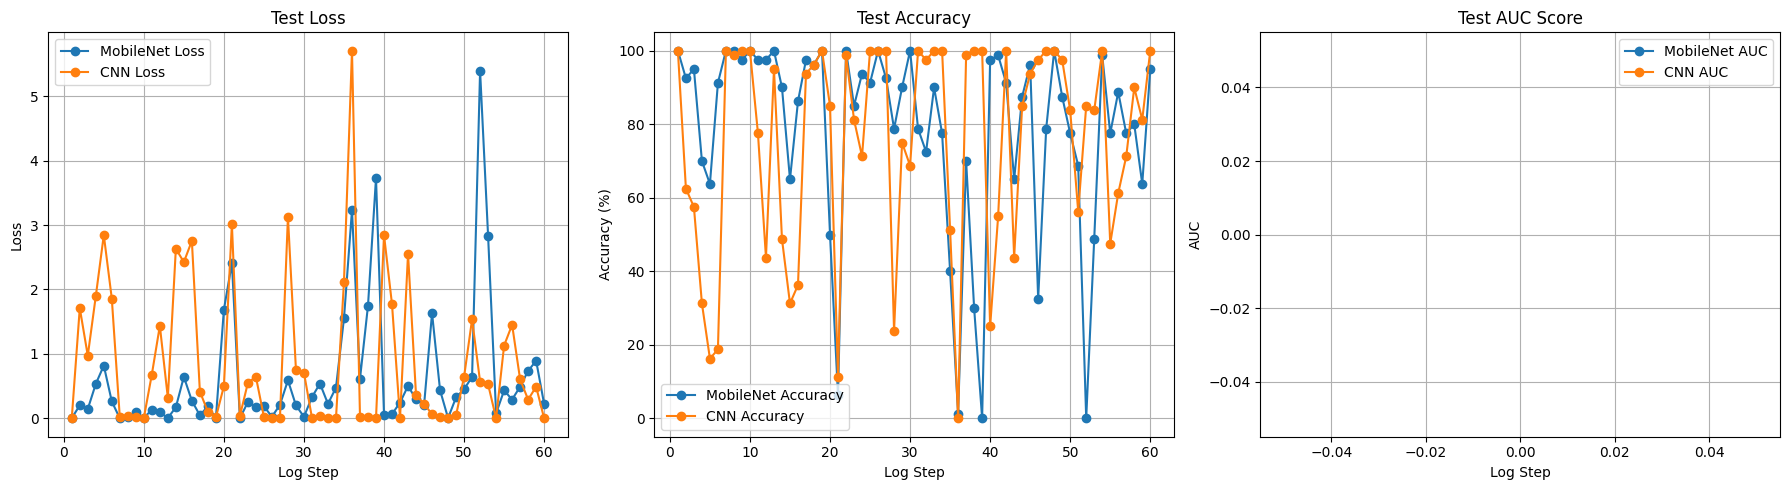

In [20]:
import matplotlib.pyplot as plt

epochs_mobilenet = range(1, len(test_losses_mobilenet) + 1)
epochs_cnn = range(1, len(test_losses) + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_mobilenet, test_losses_mobilenet, label='MobileNet Loss', marker='o')
plt.plot(epochs_cnn, test_losses, label='CNN Loss', marker='o')
plt.title('Test Loss')
plt.xlabel('Log Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_mobilenet, test_accuracies_mobilenet, label='MobileNet Accuracy', marker='o')
plt.plot(epochs_cnn, test_accuracies, label='CNN Accuracy', marker='o')
plt.title('Test Accuracy')
plt.xlabel('Log Step')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs_mobilenet, test_auc_scores_mobilenet, label='MobileNet AUC', marker='o')
plt.plot(epochs_cnn, test_auc_scores, label='CNN AUC', marker='o')
plt.title('Test AUC Score')
plt.xlabel('Log Step')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Interface for single image testing 
using gradio for a GUI to test the outputs of the CNN model

In [ ]:
import gradio as gr
# Load model
net = Net()
net.load_state_dict(torch.load("fake_image_model.pth", map_location="cpu"))

net.eval()


# Define transform and predict function
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Optional but often helpful
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict(img):
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = net(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]  # Get first sample's output

    fake_prob = probabilities[1].item()  # Assuming class index 1 = "Fake"
    real_prob = probabilities[0].item()
    return {"Fake": fake_prob, "Real": real_prob}


# Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Fake Image Detector",
    description="Upload an image to detect if it's fake or real."
)

demo.launch()